In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ

from lib.file.ROI_reader import ROIFileReader
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.laminar_dist import LaminarROI, Line, ROICreator
from lib.analysis.align import ImageAlign
from lib.analysis.cell_roi import RandomROISample
from lib.utilities import *

####################################################################################
#    Build a hw vs dist scatter and amp vs dist scatter for all high-SNR px for all
#       of Kate's data
#    Addition:
#       Titrate the size of the ROIs
#          - generate ROI file of random sample of circle ROIs of n_pixels px per ROI
####################################################################################

In [90]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/"

enable_photoZ_interaction = True
initialize_photoZ = False
snr_cutoff_signal = 5.0

roi_sizes = [i for i in range(1,11)] + [i for i in range(12,21,2)]

In [64]:
# set up PhotoZ (open it manually)
if enable_photoZ_interaction:
    aPhz = AutoPhotoZ(data_dir=data_dir)
    if initialize_photoZ:
        aPhz.prepare_photoZ()

'OK'

In [94]:
# Generate ROI files of specified sizes
roi_files = []
rfw = ROIFileWriter()
for rsz in roi_sizes:
    roi_sampler = RandomROISample(rsz)
    
    # return list of lists of pairs (px)
    roi_list = roi_sampler.take_random_sample()
    
    # convert to diode numbers for file writing
    roi_list = ROICreator(None).convert_rois_to_diode_numbers(roi_list)
    
    # file naming
    filename = data_dir + "ROIs_size_" + str(rsz) + "px.dat"
    roi_files.append(filename)
    
    # write to file
    rfw.write_regions_to_dat(filename, roi_list)

is_photoZ_selected = False
# extract all hw and amp files 
for subdir, dirs, files in os.walk(data_dir):
    for zda_file in files:
        if zda_file.endswith('.zda'):
            zda_filepath = subdir + "/" + zda_file
            print(zda_filepath)
            if enable_photoZ_interaction:
                aPhz = AutoPhotoZ(data_dir=subdir)
                # open the PhotoZ file
                if not is_photoZ_selected:
                    aPhz.select_PhotoZ()
                    is_photoZ_selected = True

                print("\n\nOpening", zda_file)
                aPhz.open_zda_file(zda_filepath)
                
                for roi_file in roi_files:
                    
                    # Open the ROI file 
                    aPhz.select_roi_tab()
                    aPhz.open_roi_file(roi_file)

                    # save SNR values from PhotoZ
                    snr_filename = subdir + "/" + "SNR.dat"
                    if enable_photoZ_interaction:
                        # aPhz.select_SNR_trace_value()
                        aPhz.save_trace_values(snr_filename)

                    # save half-width values from PhotoZ
                    hw_filename = subdir + "/" + "hw.dat" 
                    if enable_photoZ_interaction:
                        aPhz.select_half_width_trace_value()
                        aPhz.save_trace_values(hw_filename)

                    # save latency values from PhotoZ
                    amp_filename = subdir + "/" + "amp.dat"
                    if enable_photoZ_interaction:
                        aPhz.select_maxamp_trace_value()
                        aPhz.save_trace_values(amp_filename)


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-13_02-01-02_L4_intralaminar/02_01_02.zda


Opening 02_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_03-01-08_aka_02-01-08_L23_intralaminar/02_01_08.zda


Opening 02_01_08.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_04-01-01_aka_03-01-01_L4_interlaminar/03_01_01.zda


Opening 03_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_06-01-01_aka_part2_03-01-01_L4_interlaminar/03_01_01.zda


Opening 03_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_08-01-04_aka_part2_05-01-04_L4_interlaminar/05_01_04.zda


Opening 05_01_04.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_10-01-01_aka_part2_07-01-01_L4_interlaminar/07_01_01.zda


Opening 07_01_01.zd



Opening 06_01_01.zda


In [95]:
# for each subdir, take all hw/amp/electrode dist of points with SNR > cutoff
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Diode Number',  'Value'])
    return data_arr

def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr
    
concat_data = pd.DataFrame({})
snr_dfs = []
total_before_filter = 0
for subdir, dirs, files in os.walk(data_dir):
    if subdir.endswith("hw_and_amp_scatter/"):
        continue
    snr_arr = None
    for f in files:
        if '_snr.txt' in f:
            snr_arr = read_dat_arr_file(subdir + "/" + f)
            
    amp = read_dat_trace_file(subdir + "/" + 'amp.dat')
    hw = read_dat_trace_file(subdir + "/" + 'hw.dat')
    snr = read_dat_trace_file(subdir + "/" + 'SNR.dat')
    
    total_before_filter += len(amp['Value'])
    
    snr = snr.join(amp, rsuffix='amp')
    snr = snr.join(hw, rsuffix='hw')
    
    # open stim point roi as a single integer (its diode number) in variable stim_pt
    sp_file = subdir + "/" + 'electrode.dat'
    with open(sp_file, 'r') as f:
        lines = f.readlines()
    stim_pt = int(lines[-1]) # last line is always electrode location
    aux_obj = LaminarROI([stim_pt]).get_points()
    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
    
    snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]
    snr = snr[snr['Value'] > snr_cutoff_signal]
    
    snr = snr[snr['Valuehw'] > 0]
    snr = snr[snr['Valuehw'] < 15]
    snr = snr[snr['Valueamp'] > 1/1000]
    
    
    # Find distance from diode number to stim_pt
    dist = []
    for dn in snr['Diode Number']:
        px = LaminarROI([dn]).get_points()[0]
        d = Line(stim_pt, px).get_length()
        dist.append(d * 6)  # convert px -> um
    
    snr.insert(4, 'electrode_dist', dist)
    
    snr_dfs.append(snr)
    
all_snr = pd.concat(snr_dfs)
print(total_before_filter)
all_snr = all_snr[all_snr['electrode_dist'] > 100]
all_snr

4160


,Diode Number,Value,Diode Numberamp,Valueamp,electrode_dist,Diode Numberhw,Valuehw
1,2,5.16216,2,0.003334,477.631657,2,3.34766
2,3,5.60960,3,0.002547,474.948418,3,3.30060
3,4,5.19279,4,0.002246,472.326158,4,7.36340
7,8,6.16472,8,0.002286,462.467296,8,3.15799
10,11,8.59641,11,0.002398,455.763096,11,5.66684
22,23,9.32633,23,0.002910,435.403261,23,3.96285
25,26,5.98822,26,0.003021,432.041665,26,2.61267
37,38,5.09460,38,0.002476,426.000000,38,6.30548
49,50,10.49100,50,0.003857,432.041665,50,3.26058
50,51,5.18741,51,0.003150,433.081978,51,3.40328


[1.55705579e-03 4.88139831e+00]
r^2 = 0.0013426919848363614


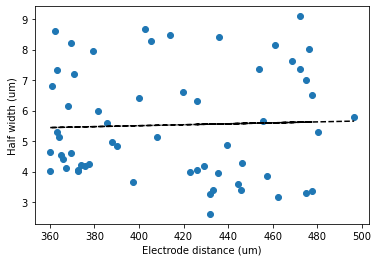

In [99]:
# scatter plot: hw vs electrode dist
x = all_snr['electrode_dist']
plt.scatter(x, all_snr['Valuehw'])
coef = np.polyfit(x, all_snr['Valuehw'], 1)
print(coef)
poly1d_fn = np.poly1d(coef) 
correlation = np.corrcoef(x, all_snr['Valuehw'])[0,1]

 # r
print("r^2 =", correlation**2)
plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(coef[1])[5])
plt.xlabel("Electrode distance (um)")
plt.ylabel("Half width (um)")
plt.show()

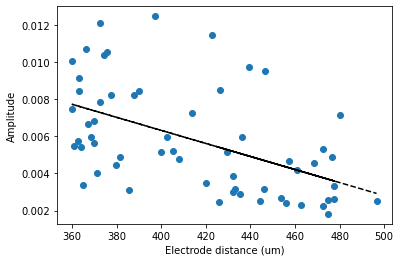

In [97]:
# scatter plot: amp vs electrode dist
plt.scatter(all_snr['electrode_dist'], all_snr['Valueamp'])
coef = np.polyfit(x, all_snr['Valueamp'], 1)
poly1d_fn = np.poly1d(coef) 
plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(coef[1])[5])
plt.xlabel("Electrode distance (um)")
plt.ylabel("Amplitude")
plt.show()